In [3]:
!pip install pyspark --quiet
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
import pyspark
from pyspark.ml import Pipeline
from pyspark.ml.linalg import Vectors
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.feature import *
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.sql import Row
from pyspark.sql.functions import *
from pyspark.sql.types import *

In [4]:
import os
import sys

from pyspark import SparkContext
from pyspark.sql import SQLContext
sc = SparkContext()
sc.version

'3.2.1'

# **وصل شدن به دیتاست**

In [15]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('ml-hw').getOrCreate()
Mdf = spark.read.csv('/content/gdrive/MyDrive/data.csv', header = True, inferSchema = True)
Mdf.show()

+----------+------+-------------+-------+----------+------+------------+----------------+---------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+--------------+----------------+--------------------+--------------+------------+-----+
|customerID|gender|SeniorCitizen|Partner|Dependents|tenure|PhoneService|   MultipleLines|InternetService|     OnlineSecurity|       OnlineBackup|   DeviceProtection|        TechSupport|        StreamingTV|    StreamingMovies|      Contract|PaperlessBilling|       PaymentMethod|MonthlyCharges|TotalCharges|Label|
+----------+------+-------------+-------+----------+------+------------+----------------+---------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+--------------+----------------+--------------------+--------------+------------+-----+
|5331-RGMTT|  Male|          1.0|    Yes|        No|  54.0|  

# **نمایش اطلاعات ستون های دیتاست**

In [63]:
Mdf.printSchema()

root
 |-- customerID: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- SeniorCitizen: double (nullable = true)
 |-- Partner: string (nullable = true)
 |-- Dependents: string (nullable = true)
 |-- tenure: double (nullable = true)
 |-- PhoneService: string (nullable = true)
 |-- MultipleLines: string (nullable = true)
 |-- InternetService: string (nullable = true)
 |-- OnlineSecurity: string (nullable = true)
 |-- OnlineBackup: string (nullable = true)
 |-- DeviceProtection: string (nullable = true)
 |-- TechSupport: string (nullable = true)
 |-- StreamingTV: string (nullable = true)
 |-- StreamingMovies: string (nullable = true)
 |-- Contract: string (nullable = true)
 |-- PaperlessBilling: string (nullable = true)
 |-- PaymentMethod: string (nullable = true)
 |-- MonthlyCharges: double (nullable = true)
 |-- TotalCharges: double (nullable = true)
 |-- Label: string (nullable = true)



# **حذف Duplicate**

In [64]:
duplicate=Mdf.dropDuplicates()
duplicate.show()
duplicate.count()


+--------------+------+-------------+-------+----------+------+------------+----------------+---------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+--------------+----------------+--------------------+--------------+------------+-----+
|    customerID|gender|SeniorCitizen|Partner|Dependents|tenure|PhoneService|   MultipleLines|InternetService|     OnlineSecurity|       OnlineBackup|   DeviceProtection|        TechSupport|        StreamingTV|    StreamingMovies|      Contract|PaperlessBilling|       PaymentMethod|MonthlyCharges|TotalCharges|Label|
+--------------+------+-------------+-------+----------+------+------------+----------------+---------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+--------------+----------------+--------------------+--------------+------------+-----+
|    3655-SNQYZ|Female|          0.0|    Yes|    

7838

# **شمارش کل مقادیر از دست رفته**

In [65]:
duplicate.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in duplicate.columns] ).show()


+----------+------+-------------+-------+----------+------+------------+-------------+---------------+--------------+------------+----------------+-----------+-----------+---------------+--------+----------------+-------------+--------------+------------+-----+
|customerID|gender|SeniorCitizen|Partner|Dependents|tenure|PhoneService|MultipleLines|InternetService|OnlineSecurity|OnlineBackup|DeviceProtection|TechSupport|StreamingTV|StreamingMovies|Contract|PaperlessBilling|PaymentMethod|MonthlyCharges|TotalCharges|Label|
+----------+------+-------------+-------+----------+------+------------+-------------+---------------+--------------+------------+----------------+-----------+-----------+---------------+--------+----------------+-------------+--------------+------------+-----+
|       253|   235|          266|    225|       242|   225|         269|          263|            230|           230|         243|             254|        264|        249|            219|     230|             257| 

# **customerID و label حذف مقادیر از دست رفته روی ستون های**

In [18]:
df = duplicate.na.drop(subset=["Label"])
df = df.na.drop(subset=["customerID"])

# **tenure و Monthlycharges و totalcharges پرکردن مقادیر از دست رفته روی ستون های**
# **Mean با استفاده از**

In [20]:
TotalCharges1 = df.select(["TotalCharges"]).toPandas().mean()[0]
df = df.na.fill( TotalCharges1,subset='TotalCharges')
MonthCharges1 = df.select(["MonthlyCharges"]).toPandas().mean()[0]
df = df.na.fill( MonthCharges1,subset='MonthlyCharges')
tenure1 = df.select(["tenure"]).toPandas().mean()[0]
df = df.na.fill(tenure1,subset='tenure')
df.printSchema()

root
 |-- customerID: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- SeniorCitizen: double (nullable = true)
 |-- Partner: string (nullable = true)
 |-- Dependents: string (nullable = true)
 |-- tenure: double (nullable = false)
 |-- PhoneService: string (nullable = true)
 |-- MultipleLines: string (nullable = true)
 |-- InternetService: string (nullable = true)
 |-- OnlineSecurity: string (nullable = true)
 |-- OnlineBackup: string (nullable = true)
 |-- DeviceProtection: string (nullable = true)
 |-- TechSupport: string (nullable = true)
 |-- StreamingTV: string (nullable = true)
 |-- StreamingMovies: string (nullable = true)
 |-- Contract: string (nullable = true)
 |-- PaperlessBilling: string (nullable = true)
 |-- PaymentMethod: string (nullable = true)
 |-- MonthlyCharges: double (nullable = false)
 |-- TotalCharges: double (nullable = false)
 |-- Label: string (nullable = true)



# **fill missing values on string type features using mod**

In [21]:
cunt = df.groupBy("gender").count()
mod= cunt.join(cunt.agg(max("count").alias("max_")), col("count") == col("max_")).limit(1).select("gender")
df=df.na.fill(mod.first()[0],["gender"])

In [22]:
cunt = df.groupBy("Partner").count()
mod= cunt.join(cunt.agg(max("count").alias("max_")), col("count") == col("max_")).limit(1).select("Partner")
df=df.na.fill(mod.first()[0],["Partner"])

In [23]:
cunt = df.groupBy("Dependents").count()
mod= cunt.join(cunt.agg(max("count").alias("max_")), col("count") == col("max_")).limit(1).select("Dependents")
df=df.na.fill(mod.first()[0],["Dependents"])

In [24]:
cunt = df.groupBy("MultipleLines").count()
mod= cunt.join(cunt.agg(max("count").alias("max_")), col("count") == col("max_")).limit(1).select("MultipleLines")
df=df.na.fill(mod.first()[0],["MultipleLines"])

In [25]:
cunt = df.groupBy("InternetService").count()
mod= cunt.join(cunt.agg(max("count").alias("max_")), col("count") == col("max_")).limit(1).select("InternetService")
df=df.na.fill(mod.first()[0],["InternetService"])

In [27]:
cunt = df.groupBy("OnlineSecurity").count()
mod= cunt.join(cunt.agg(max("count").alias("max_")), col("count") == col("max_")).limit(1).select("OnlineSecurity")
df=df.na.fill(mod.first()[0],["OnlineSecurity"])

In [26]:
cunt = df.groupBy("OnlineBackup").count()
mod= cunt.join(cunt.agg(max("count").alias("max_")), col("count") == col("max_")).limit(1).select("OnlineBackup")
df=df.na.fill(mod.first()[0],["OnlineBackup"])

In [28]:
cunt = df.groupBy("DeviceProtection").count()
mod= cunt.join(cunt.agg(max("count").alias("max_")), col("count") == col("max_")).limit(1).select("DeviceProtection")
df=df.na.fill(mod.first()[0],["DeviceProtection"])

In [29]:
cunt = df.groupBy("TechSupport").count()
mod= cunt.join(cunt.agg(max("count").alias("max_")), col("count") == col("max_")).limit(1).select("TechSupport")
df=df.na.fill(mod.first()[0],["TechSupport"])

In [30]:
cunt = df.groupBy("StreamingTV").count()
mod= cunt.join(cunt.agg(max("count").alias("max_")), col("count") == col("max_")).limit(1).select("StreamingTV")
df=df.na.fill(mod.first()[0],["StreamingTV"])

In [31]:
cunt = df.groupBy("StreamingMovies").count()
mod= cunt.join(cunt.agg(max("count").alias("max_")), col("count") == col("max_")).limit(1).select("StreamingMovies")
df=df.na.fill(mod.first()[0],["StreamingMovies"])

In [32]:
cunt = df.groupBy("PhoneService").count()
mod= cunt.join(cunt.agg(max("count").alias("max_")), col("count") == col("max_")).limit(1).select("PhoneService")
df=df.na.fill(mod.first()[0],["PhoneService"])

In [33]:
cunt = df.groupBy("PaperlessBilling").count()
mod= cunt.join(cunt.agg(max("count").alias("max_")), col("count") == col("max_")).limit(1).select("PaperlessBilling")
df=df.na.fill(mod.first()[0],["PaperlessBilling"])

In [34]:
cunt = df.groupBy("Contract").count()
mod= cunt.join(cunt.agg(max("count").alias("max_")), col("count") == col("max_")).limit(1).select("Contract")
df=df.na.fill(mod.first()[0],["Contract"])

In [35]:
cunt = df.groupBy("PaymentMethod").count()
mod= cunt.join(cunt.agg(max("count").alias("max_")), col("count") == col("max_")).limit(1).select("PaymentMethod")
df=df.na.fill(mod.first()[0],["PaymentMethod"])

In [36]:
cunt = df.groupBy("SeniorCitizen").count()
mod= cunt.join(cunt.agg(max("count").alias("max_")), col("count") == col("max_")).limit(1).select("SeniorCitizen")
df=df.na.fill(mod.first()[0],["SeniorCitizen"])

# **شمارش مقادیر از دست رفته بعد از عملیات فوق**

In [39]:
df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df.columns] ).show()
df.printSchema()

+----------+------+-------------+-------+----------+------+------------+-------------+---------------+--------------+------------+----------------+-----------+-----------+---------------+--------+----------------+-------------+--------------+------------+-----+
|customerID|gender|SeniorCitizen|Partner|Dependents|tenure|PhoneService|MultipleLines|InternetService|OnlineSecurity|OnlineBackup|DeviceProtection|TechSupport|StreamingTV|StreamingMovies|Contract|PaperlessBilling|PaymentMethod|MonthlyCharges|TotalCharges|Label|
+----------+------+-------------+-------+----------+------+------------+-------------+---------------+--------------+------------+----------------+-----------+-----------+---------------+--------+----------------+-------------+--------------+------------+-----+
|         0|     0|            0|      0|         0|     0|           0|            0|              0|             0|           0|               0|          0|          0|              0|       0|               0| 

# **EDA**

## **Histogram of spread of each feature**

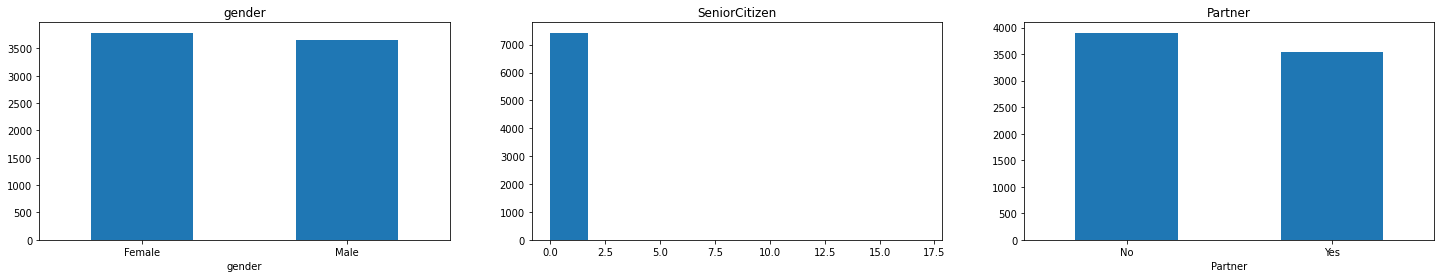

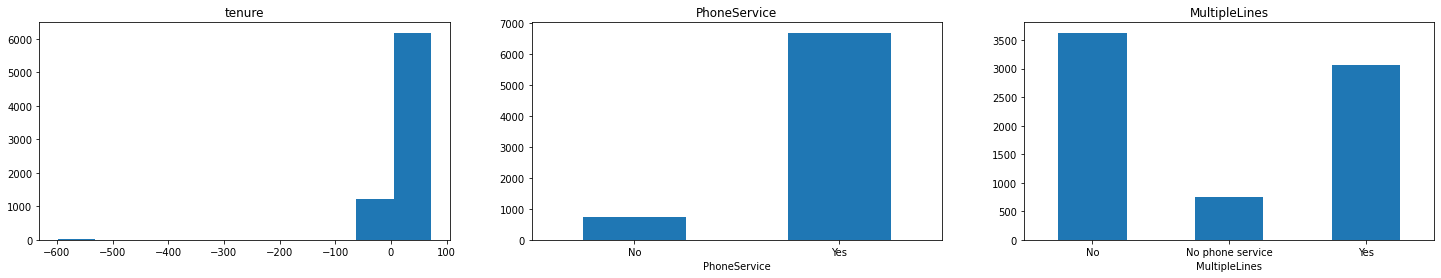

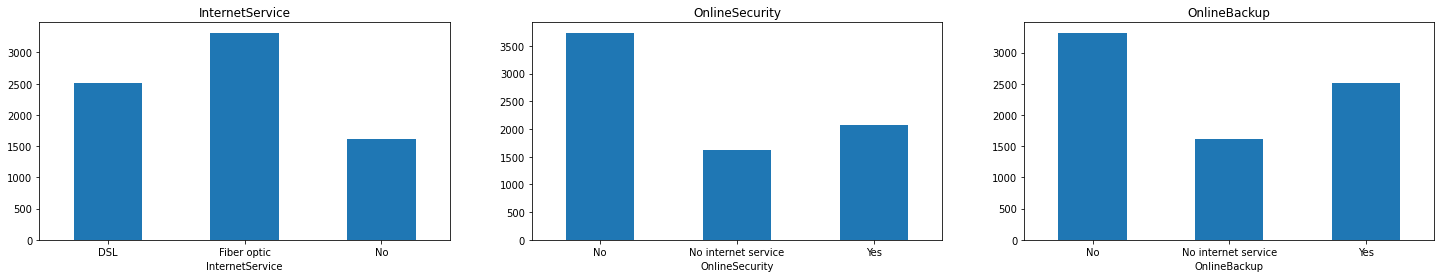

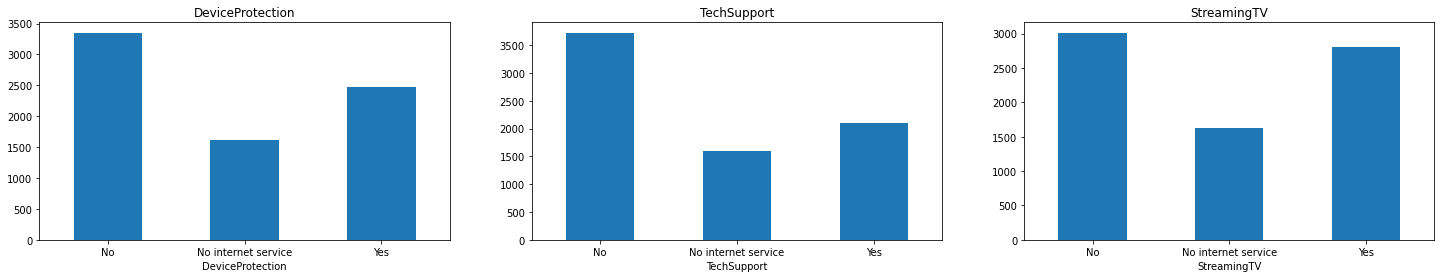

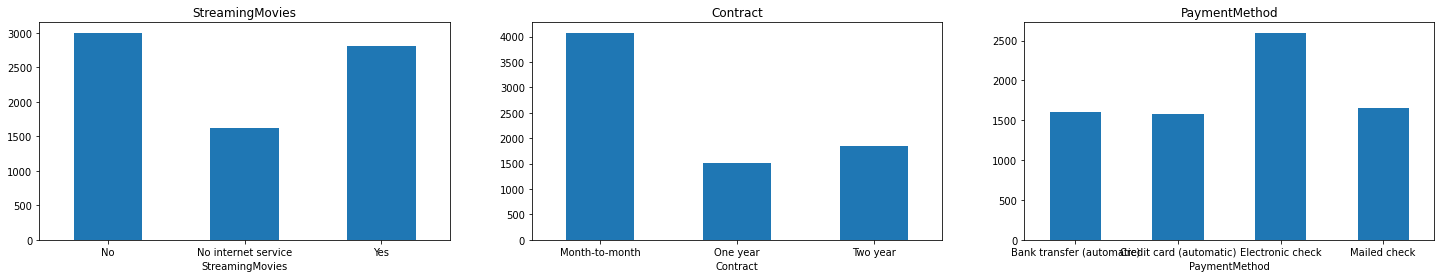

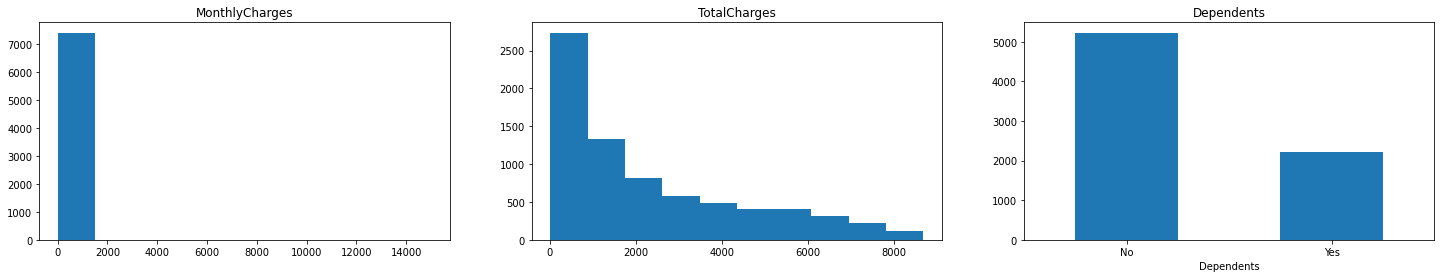

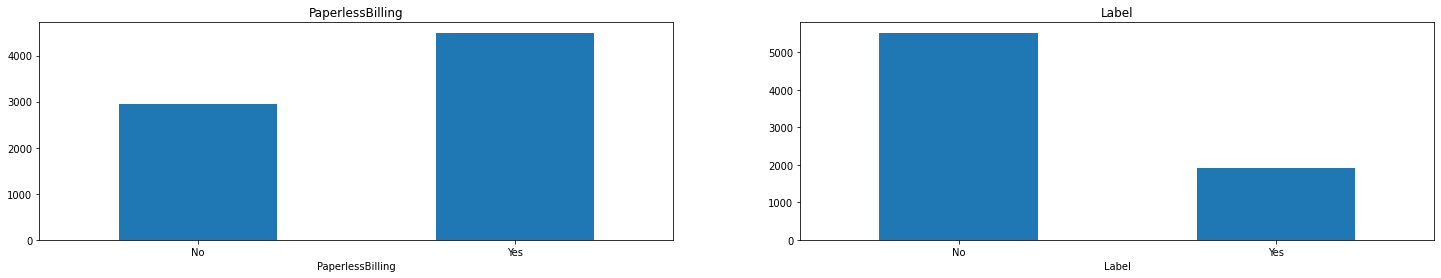

In [66]:
!pip install -q handyspark
from handyspark import *

h_df = df.toHandy()
from matplotlib import pyplot as plt

fig, axs = plt.subplots(1, 3, figsize=(25, 4))
h_df.cols['gender'].hist(ax=axs[0])
h_df.cols['SeniorCitizen'].hist(ax=axs[1])
h_df.cols['Partner'].hist(ax=axs[2])

fig, axs = plt.subplots(1, 3, figsize=(25, 4))
h_df.cols['tenure'].hist(ax=axs[0])
h_df.cols['PhoneService'].hist(ax=axs[1])
h_df.cols['MultipleLines'].hist(ax=axs[2])

fig, axs = plt.subplots(1, 3, figsize=(25, 4))
h_df.cols['InternetService'].hist(ax=axs[0])
h_df.cols['OnlineSecurity'].hist(ax=axs[1])
h_df.cols['OnlineBackup'].hist(ax=axs[2])

fig, axs = plt.subplots(1, 3, figsize=(25, 4))
h_df.cols['DeviceProtection'].hist(ax=axs[0])
h_df.cols['TechSupport'].hist(ax=axs[1])
h_df.cols['StreamingTV'].hist(ax=axs[2])

fig, axs = plt.subplots(1, 3, figsize=(25, 4))
h_df.cols['StreamingMovies'].hist(ax=axs[0])
h_df.cols['Contract'].hist(ax=axs[1])
h_df.cols['PaymentMethod'].hist(ax=axs[2])

fig, axs = plt.subplots(1, 3, figsize=(25, 4))
h_df.cols['MonthlyCharges'].hist(ax=axs[0])
h_df.cols['TotalCharges'].hist(ax=axs[1])
h_df.cols['Dependents'].hist(ax=axs[2])

fig, axs = plt.subplots(1, 2, figsize=(25, 4))
h_df.cols['PaperlessBilling'].hist(ax=axs[0])
h_df.cols['Label'].hist(ax=axs[1])



## **Histogram of relation between Label and each other feature**

(<Figure size 1440x360 with 2 Axes>,
  <matplotlib.axes._subplots.AxesSubplot at 0x7f687f379e50>])

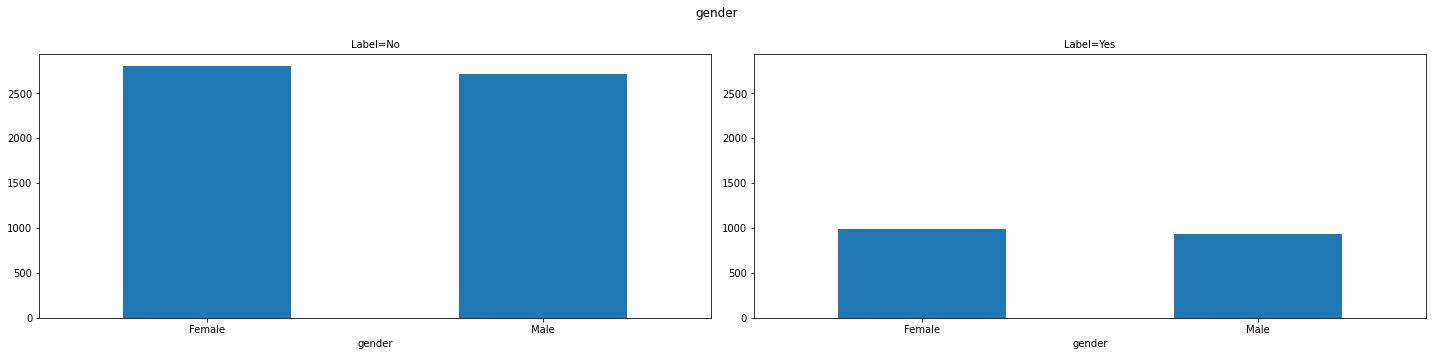

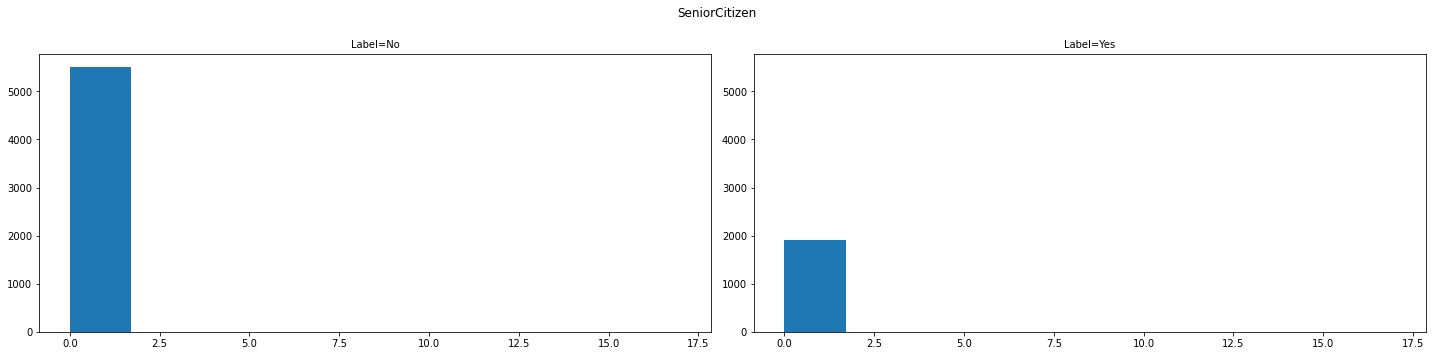

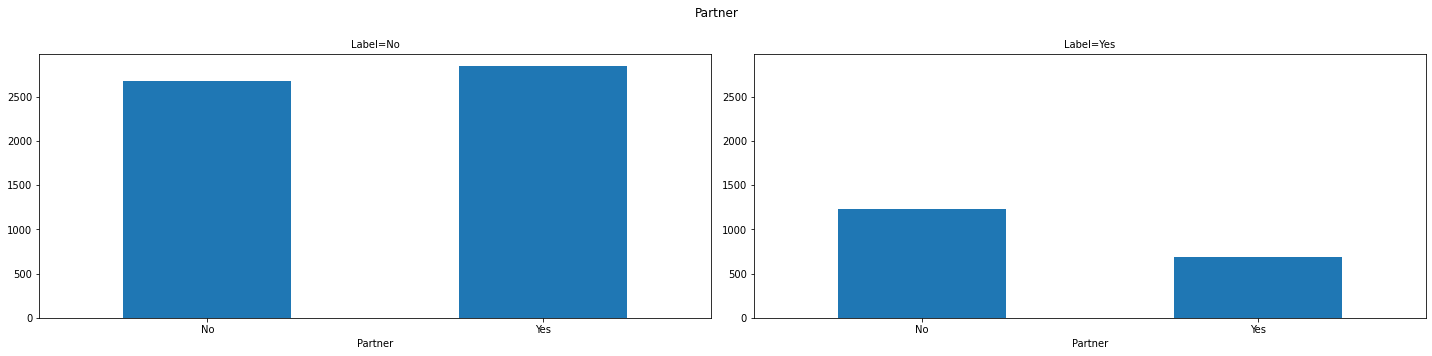

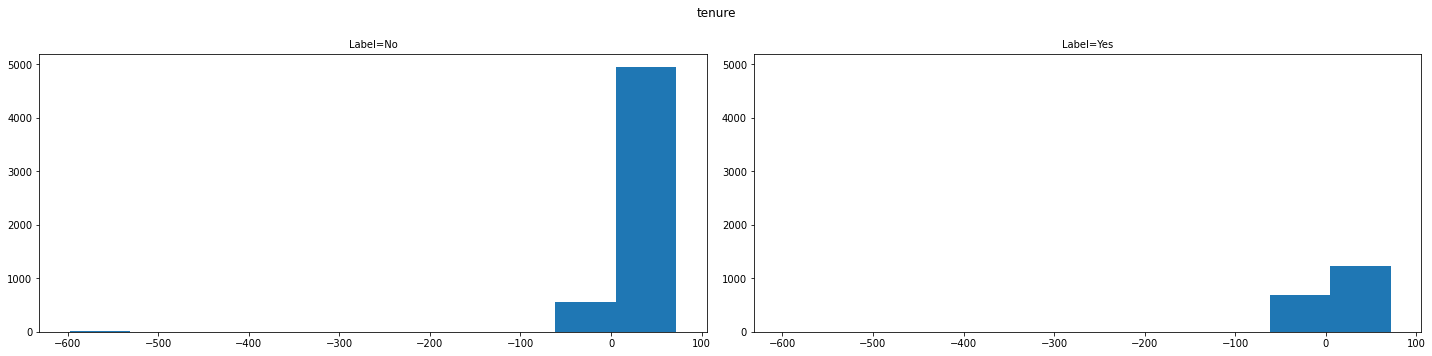

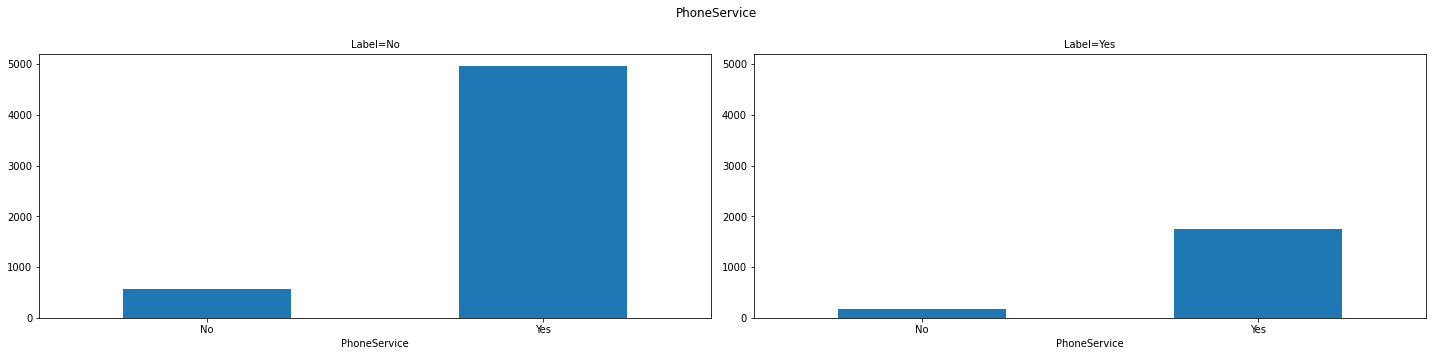

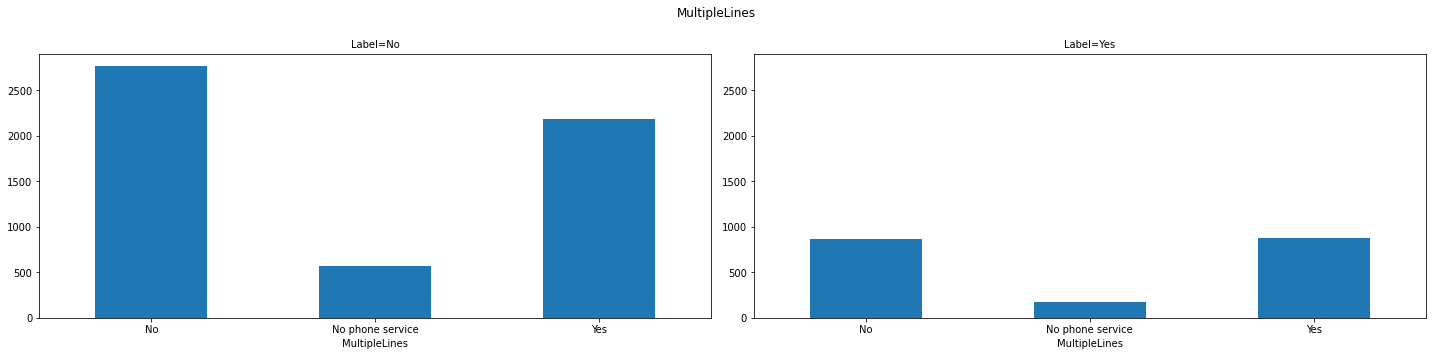

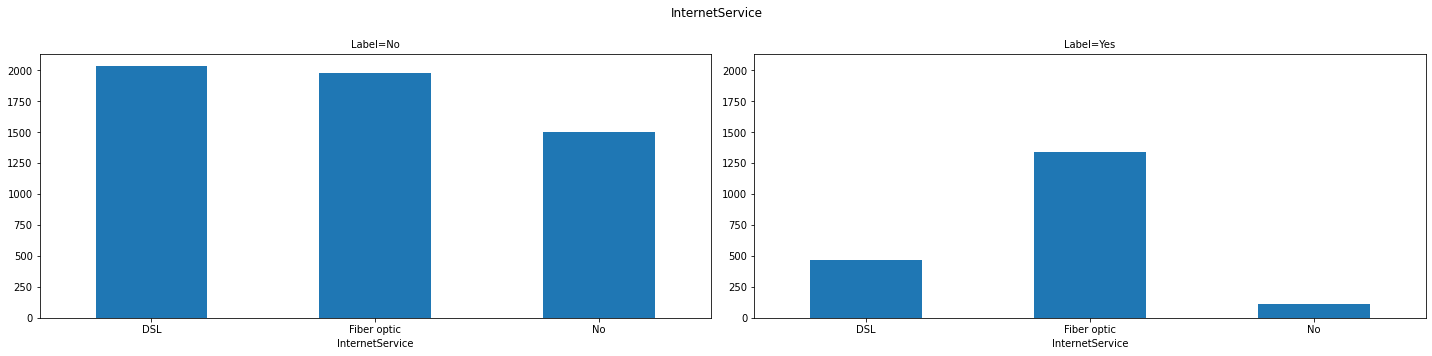

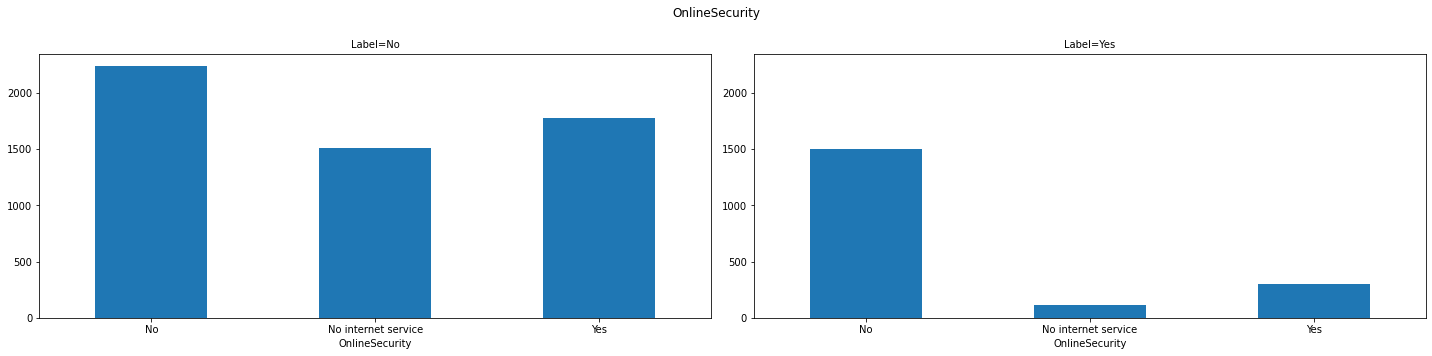

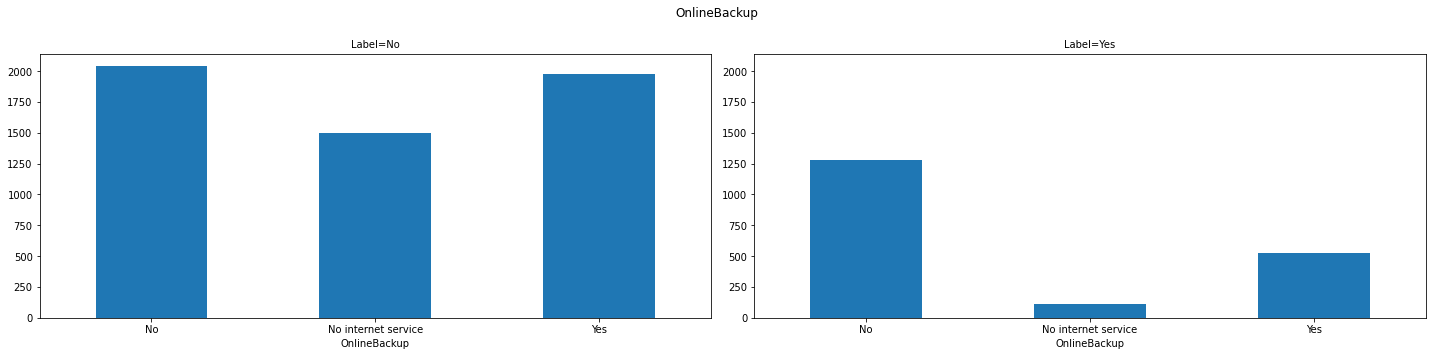

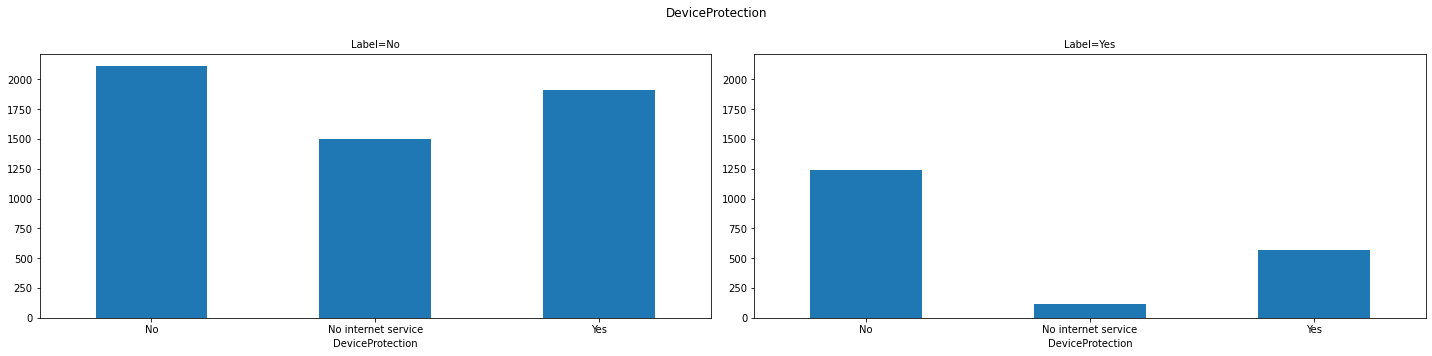

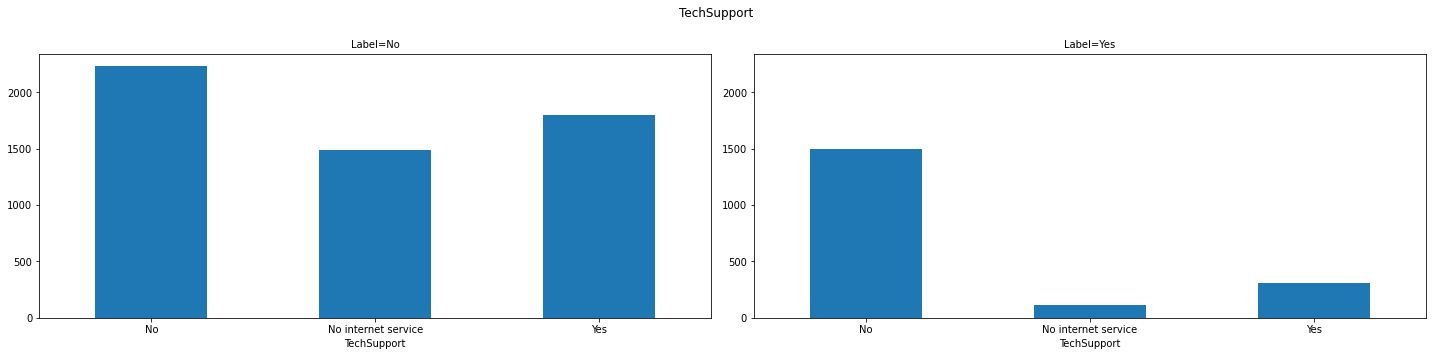

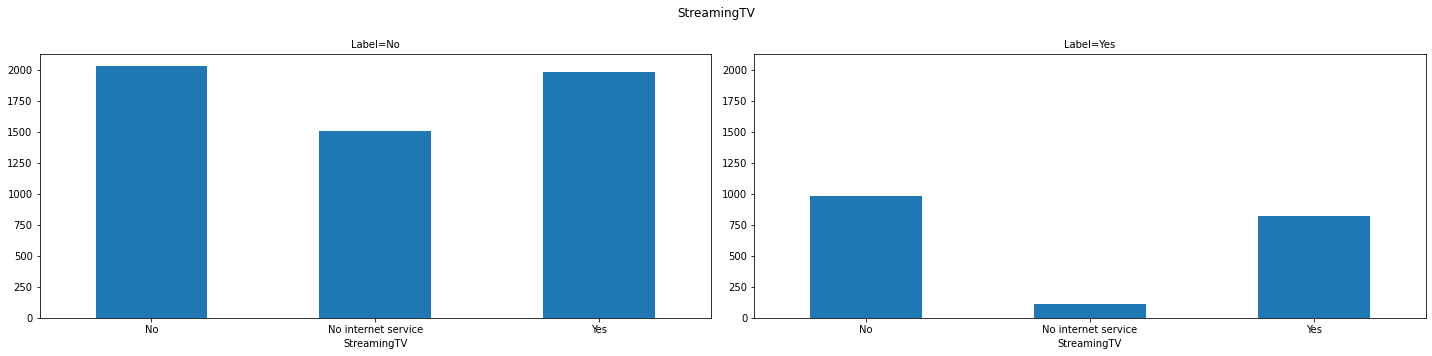

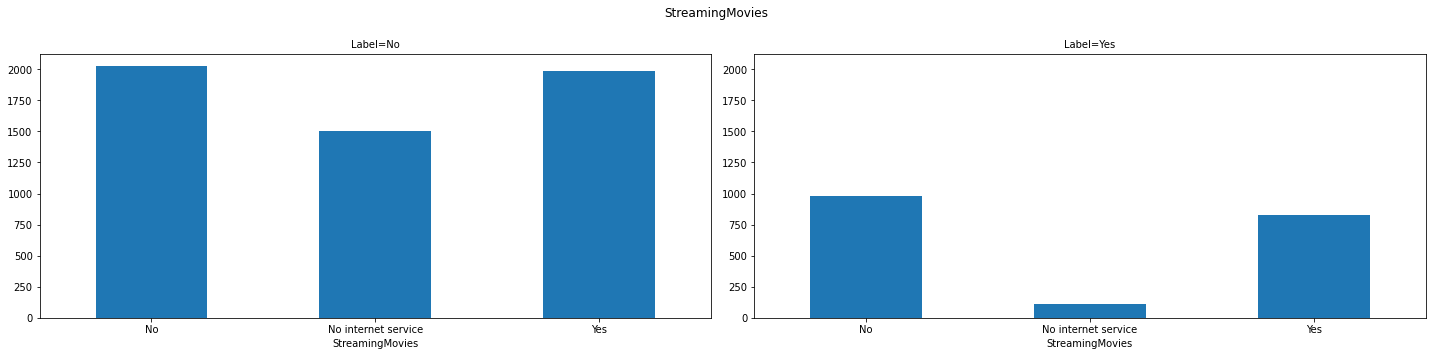

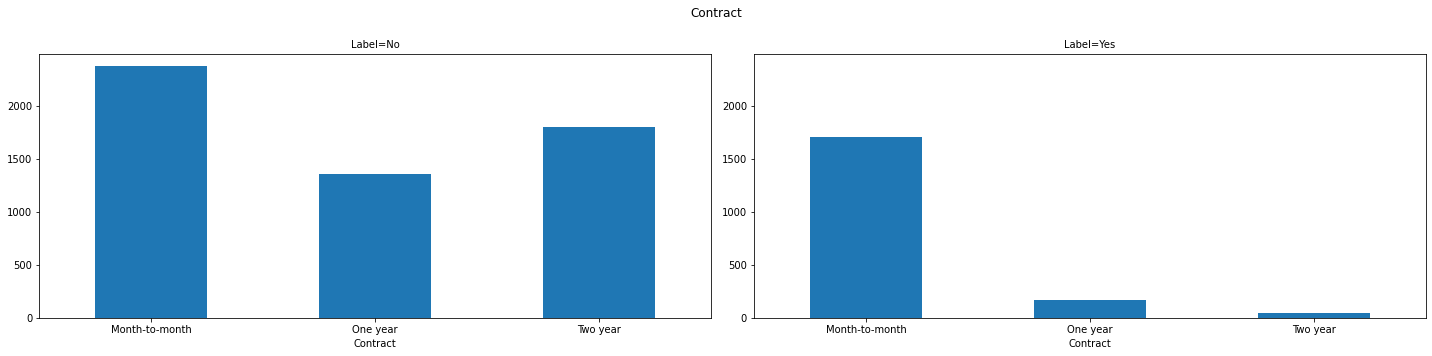

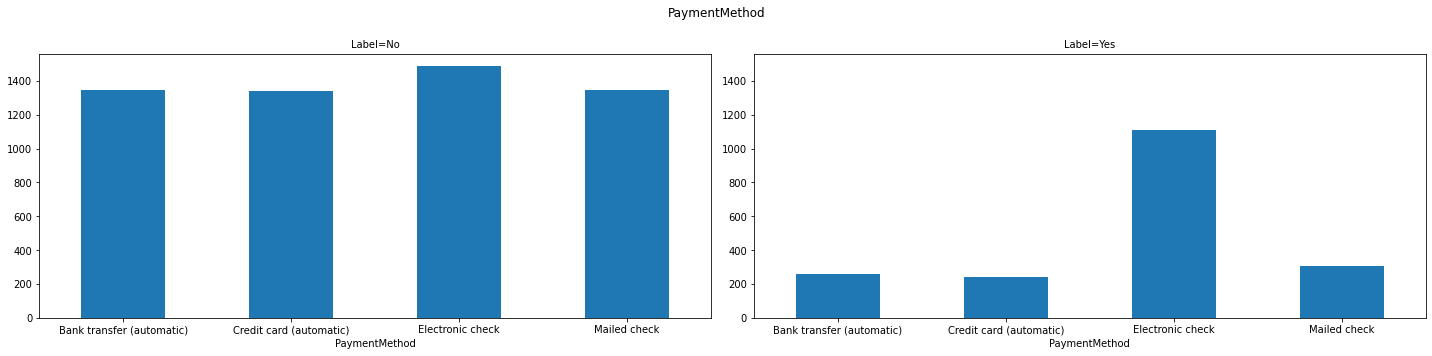

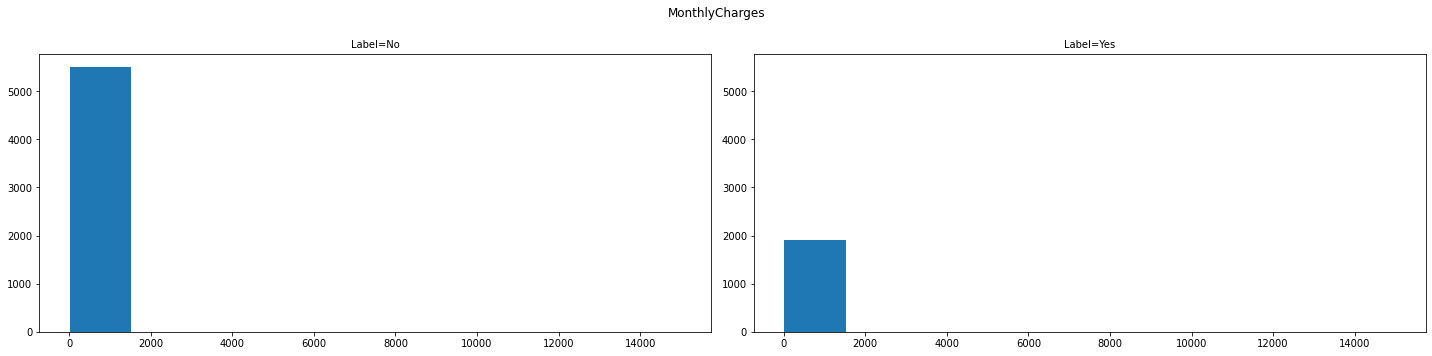

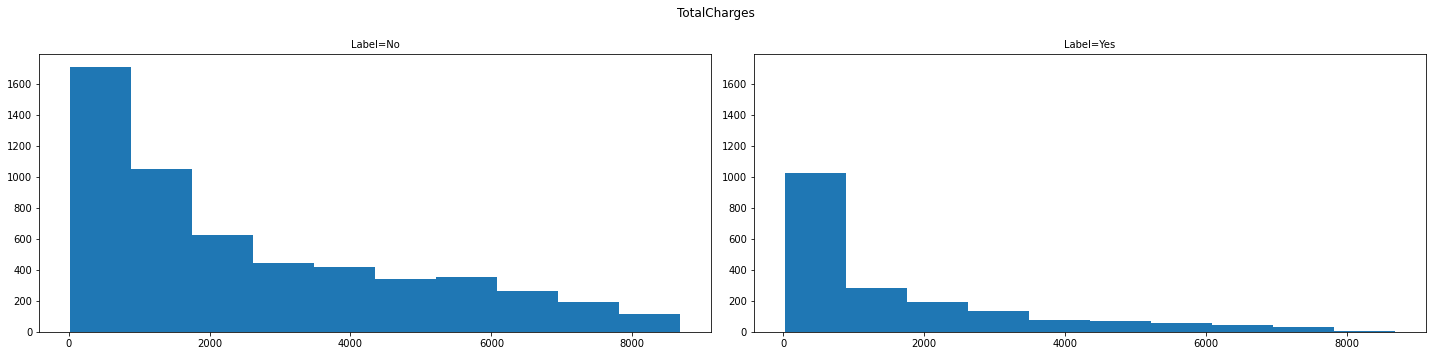

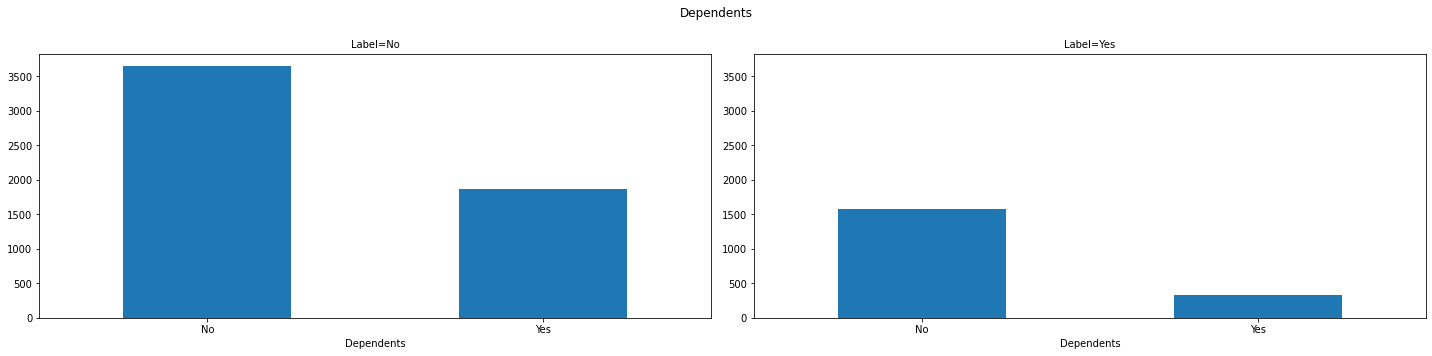

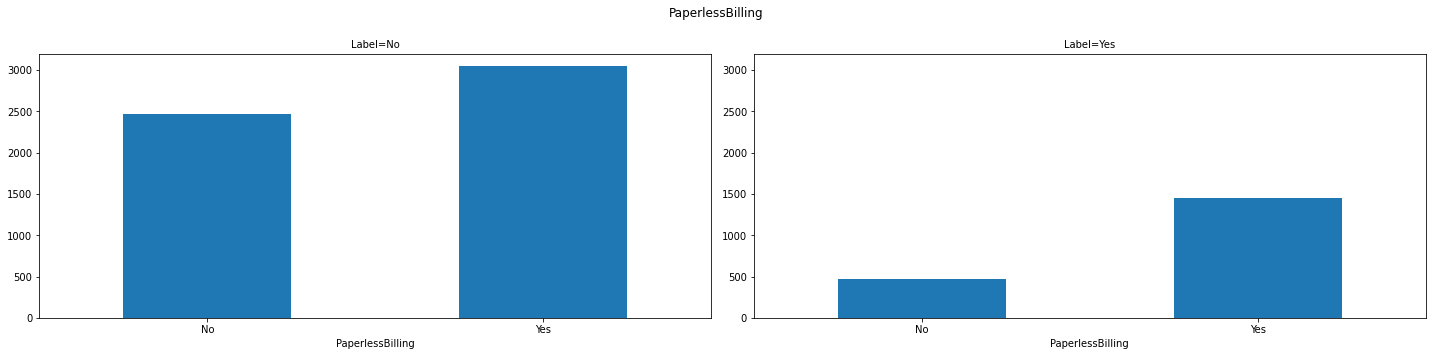

In [43]:
h_df.stratify(['Label']).cols['gender'].hist(figsize=(20, 5))
h_df.stratify(['Label']).cols['SeniorCitizen'].hist(figsize=(20, 5))
h_df.stratify(['Label']).cols['Partner'].hist(figsize=(20, 5))
h_df.stratify(['Label']).cols['tenure'].hist(figsize=(20, 5))
h_df.stratify(['Label']).cols['PhoneService'].hist(figsize=(20, 5))
h_df.stratify(['Label']).cols['MultipleLines'].hist(figsize=(20, 5))
h_df.stratify(['Label']).cols['InternetService'].hist(figsize=(20, 5))
h_df.stratify(['Label']).cols['OnlineSecurity'].hist(figsize=(20, 5))
h_df.stratify(['Label']).cols['OnlineBackup'].hist(figsize=(20, 5))
h_df.stratify(['Label']).cols['DeviceProtection'].hist(figsize=(20, 5))
h_df.stratify(['Label']).cols['TechSupport'].hist(figsize=(20, 5))
h_df.stratify(['Label']).cols['StreamingTV'].hist(figsize=(20, 5))
h_df.stratify(['Label']).cols['StreamingMovies'].hist(figsize=(20, 5))
h_df.stratify(['Label']).cols['Contract'].hist(figsize=(20, 5))
h_df.stratify(['Label']).cols['PaymentMethod'].hist(figsize=(20,5))
h_df.stratify(['Label']).cols['MonthlyCharges'].hist(figsize=(20, 5))
h_df.stratify(['Label']).cols['TotalCharges'].hist(figsize=(20, 5))
h_df.stratify(['Label']).cols['Dependents'].hist(figsize=(20, 5))
h_df.stratify(['Label']).cols['PaperlessBilling'].hist(figsize=(20, 5))

# **Compute Correlation on feature**


INFO: Safety is ON - returning up to 1000 instances.


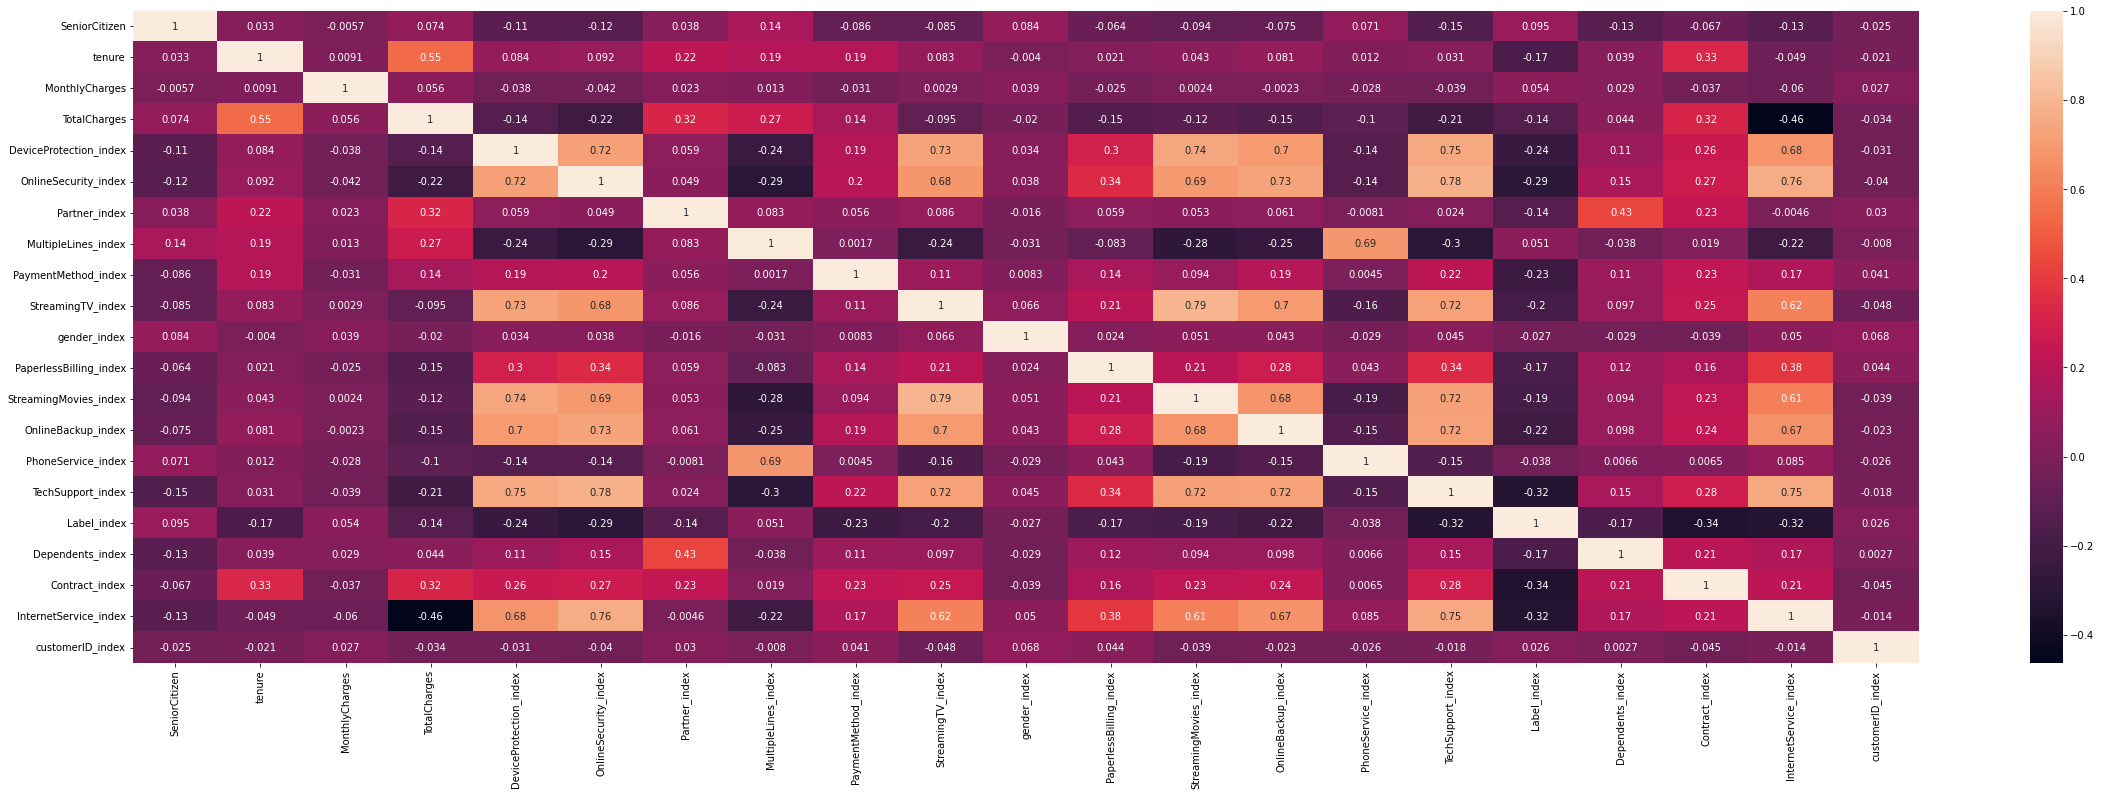

In [67]:
from matplotlib.cbook import index_of
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer

indx = [StringIndexer(inputCol=column, outputCol=column+"_index").fit(df) for column in list(set(df.columns)-set(['SeniorCitizen','tenure','MonthlyCharges','TotalCharges'])) ]

pipeline = Pipeline(stages=indx)
df_df= pipeline.fit(df).transform(df)
df_df = df_df.drop('gender','Partner','Dependent','PhoneService','MultipleLines','InternetService','OnlineSecurity','OnlineBackup','DeviceProtection','TechSupport','StreamingTV','StreamingMovies','Contract','PaperlessBilling','PaymentMethod','Label','customerID','Dependents')
h_df1 = df_df.toHandy()

from pyspark.ml.stat import Correlation
import seaborn as sns

dta = h_df1.toPandas()
plt.figure(figsize=(40,12))
sns.heatmap(dta.corr(), annot=True)
plt.show()

# **feature engineering**

In [68]:
hasher = FeatureHasher(inputCols=["SeniorCitizen","Partner", "Dependents", "tenure", "MultipleLines", "InternetService","OnlineSecurity", "OnlineBackup", "DeviceProtection", "TechSupport", "StreamingTV", "StreamingMovies", "Contract","PaperlessBilling","PaymentMethod","TotalCharges"],
                       outputCol="features")
hasher1 = FeatureHasher(inputCols=["gender", "SeniorCitizen", "Partner", "Dependents","tenure", "PhoneService", "MultipleLines", "InternetService","OnlineSecurity", "OnlineBackup", "DeviceProtection", "TechSupport", "StreamingTV", "StreamingMovies", "Contract","PaperlessBilling","PaymentMethod", "MonthlyCharges", "TotalCharges"],
                       outputCol="features")
Featurized = hasher.transform(df)
Featurized1= hasher1.transform(duplicate)
Featurized = Featurized["Label","customerID","features"]
Featurized1 = Featurized1["Label","customerID","features"]

In [70]:
Featurized.show()
Featurized1.show()


+-----+--------------+--------------------+
|Label|    customerID|            features|
+-----+--------------+--------------------+
|   No|    3655-SNQYZ|(262144,[40671,62...|
|   No|    7114-AEOZE|(262144,[20545,53...|
|  Yes|    8621-MNIHH|(262144,[34708,40...|
|  Yes|    4580-TMHJU|(262144,[7831,205...|
|   No|    5553-AOINX|(262144,[34708,40...|
|   No|    5902-WBLSE|(262144,[20545,34...|
|   No|    2388-LAESQ|(262144,[34708,40...|
|  Yes|    2506-CLAKW|(262144,[20545,34...|
|   No|    4976-LNFVV|(262144,[4236,783...|
|   No|    3642-GKTCT|(262144,[34708,40...|
|  Yes|    2223-KAGMX|(262144,[20545,53...|
|   No|    9003-CPATH|(262144,[7831,773...|
|   No|    7634-WSWDB|(262144,[4236,347...|
|   No|    6997-UVGOX|(262144,[20545,40...|
|  Yes|4412-YLTKFcsas|(262144,[7831,347...|
|   No|    3692-JHONH|(262144,[34708,40...|
|  Yes|    5202-IVJNU|(262144,[4236,783...|
|   No|    7879-CGSFV|(262144,[20545,34...|
|   No|    0582-AVCLN|(262144,[20545,53...|
|   No|    2229-VWQJH|(262144,[7

In [71]:
def f(x): 
    if(x == 'Yes'):
       return 1

    else:
       return 0

Featurized = Featurized.withColumn("label", when(col("Label")=='Yes', 1).otherwise(0))
Featurized= Featurized.withColumnRenamed("Label","label")
Featurized1 = Featurized1.withColumn("label", when(col("Label")=='Yes', 1).otherwise(0))
Featurized1= Featurized1.withColumnRenamed("Label","label")
Featurized.select('Label','customerID','features').show()
Featurized1.select('Label','customerID','features').show()

+-----+--------------+--------------------+
|Label|    customerID|            features|
+-----+--------------+--------------------+
|    0|    3655-SNQYZ|(262144,[40671,62...|
|    0|    7114-AEOZE|(262144,[20545,53...|
|    1|    8621-MNIHH|(262144,[34708,40...|
|    1|    4580-TMHJU|(262144,[7831,205...|
|    0|    5553-AOINX|(262144,[34708,40...|
|    0|    5902-WBLSE|(262144,[20545,34...|
|    0|    2388-LAESQ|(262144,[34708,40...|
|    1|    2506-CLAKW|(262144,[20545,34...|
|    0|    4976-LNFVV|(262144,[4236,783...|
|    0|    3642-GKTCT|(262144,[34708,40...|
|    1|    2223-KAGMX|(262144,[20545,53...|
|    0|    9003-CPATH|(262144,[7831,773...|
|    0|    7634-WSWDB|(262144,[4236,347...|
|    0|    6997-UVGOX|(262144,[20545,40...|
|    1|4412-YLTKFcsas|(262144,[7831,347...|
|    0|    3692-JHONH|(262144,[34708,40...|
|    1|    5202-IVJNU|(262144,[4236,783...|
|    0|    7879-CGSFV|(262144,[20545,34...|
|    0|    0582-AVCLN|(262144,[20545,53...|
|    0|    2229-VWQJH|(262144,[7

# **logestic regression**

In [51]:
train , test = Featurized.randomSplit(weights=[0.8,0.2])
train1, test1 = Featurized1.randomSplit(weights=[0.8,0.2])

In [52]:
learning = LogisticRegression(maxIter=100,regParam=0.01)
learning.explainParams()

"aggregationDepth: suggested depth for treeAggregate (>= 2). (default: 2)\nelasticNetParam: the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty. (default: 0.0)\nfamily: The name of family which is a description of the label distribution to be used in the model. Supported options: auto, binomial, multinomial (default: auto)\nfeaturesCol: features column name. (default: features)\nfitIntercept: whether to fit an intercept term. (default: True)\nlabelCol: label column name. (default: label)\nlowerBoundsOnCoefficients: The lower bounds on coefficients if fitting under bound constrained optimization. The bound matrix must be compatible with the shape (1, number of features) for binomial regression, or (number of classes, number of features) for multinomial regression. (undefined)\nlowerBoundsOnIntercepts: The lower bounds on intercepts if fitting under bound constrained optimization. The bounds vector size must be

# **learn model and train coefficents**

In [55]:
model = learning.fit(train)
model.coefficients

SparseVector(262144, {4236: 0.1255, 7831: -0.0702, 20545: -0.1924, 34708: 0.1253, 40671: 0.2214, 53807: -0.1326, 57644: -0.1482, 59103: -0.1795, 62450: -0.1797, 72938: -0.831, 74746: -0.0264, 77335: -0.0891, 97174: -0.1001, 97284: -0.2066, 100321: 0.1063, 109041: -0.0583, 112867: -0.1063, 119757: 0.1712, 139220: 0.2223, 139721: -0.0388, 143274: -0.0025, 144208: -0.4178, 148734: 0.0264, 152436: -0.1253, 153197: -0.0884, 163470: 0.2402, 180881: -0.2057, 190858: 0.1558, 190991: 0.2571, 196278: 0.0738, 203276: 0.1512, 205898: -0.0206, 213513: -0.2296, 218283: 0.7254, 222701: 0.1181, 240448: -0.1432, 241506: 0.4656, 246667: -0.0003, 256762: -0.1225, 257928: -0.0053})

In [56]:
model1 = learning.fit(train1)
model1.coefficients

SparseVector(262144, {4236: 0.1594, 7831: 0.0539, 20545: 0.0843, 20762: 0.0, 34708: 0.2837, 35396: 0.1928, 40671: 0.3147, 53807: -0.0365, 57644: -0.0168, 59103: -0.0222, 62450: -0.027, 72938: -0.7553, 74746: -0.0424, 77335: -0.1144, 97174: -0.1318, 97284: -0.0517, 100321: 0.117, 109041: -0.0938, 112867: -0.0007, 119757: 0.3466, 124394: 0.4803, 139220: 0.1087, 139721: 0.0026, 143274: -0.0029, 144208: -0.2001, 144894: 0.2714, 148734: 0.0367, 152436: -0.0866, 153197: -0.0146, 163470: 0.2808, 180881: -0.2844, 190858: 0.2047, 190991: 0.3885, 196278: 0.2467, 203276: 0.3849, 205898: -0.017, 213513: -0.0192, 218283: 0.8404, 222701: 0.0997, 240448: -0.1083, 241506: 0.6775, 246667: -0.0002, 253914: 0.2084, 256762: -0.0551, 257928: 0.179})

# **test model**

In [57]:
model_t = model.transform(test)
model_t.show()

+-----+----------+--------------------+--------------------+--------------------+----------+
|label|customerID|            features|       rawPrediction|         probability|prediction|
+-----+----------+--------------------+--------------------+--------------------+----------+
|    0|0016-QLJIS|(262144,[34708,40...|[3.99230151072422...|[0.98187730810345...|       0.0|
|    0|0017-DINOC|(262144,[4236,783...|[3.39954016191884...|[0.96769016113561...|       0.0|
|    0|0017-IUDMW|(262144,[34708,40...|[3.96726607077129...|[0.98142640482644...|       0.0|
|    0|0023-UYUPN|(262144,[53807,57...|[2.46849409505783...|[0.92190341232537...|       0.0|
|    0|0048-PIHNL|(262144,[20545,53...|[3.16158462547389...|[0.95936276938249...|       0.0|
|    0|0058-EVZWM|(262144,[7831,347...|[0.93847470306099...|[0.71879145160223...|       0.0|
|    0|0078-XZMHT|(262144,[34708,40...|[3.59087764138359...|[0.97316580956464...|       0.0|
|    0|0089-IIQKO|(262144,[34708,40...|[0.58402388649319...|[0.6419927

In [58]:
model1_t = model1.transform(test)
model1_t.show()

+-----+----------+--------------------+--------------------+--------------------+----------+
|label|customerID|            features|       rawPrediction|         probability|prediction|
+-----+----------+--------------------+--------------------+--------------------+----------+
|    0|0016-QLJIS|(262144,[34708,40...|[4.34856880043863...|[0.98723963350984...|       0.0|
|    0|0017-DINOC|(262144,[4236,783...|[4.29256118713454...|[0.98651447602003...|       0.0|
|    0|0017-IUDMW|(262144,[34708,40...|[4.27355615213236...|[0.98625928755933...|       0.0|
|    0|0023-UYUPN|(262144,[53807,57...|[3.00726364386980...|[0.95290119736073...|       0.0|
|    0|0048-PIHNL|(262144,[20545,53...|[3.73381205637680...|[0.97665640026546...|       0.0|
|    0|0058-EVZWM|(262144,[7831,347...|[1.29401338889110...|[0.78482572218056...|       0.0|
|    0|0078-XZMHT|(262144,[34708,40...|[3.99615207917575...|[0.98194569913521...|       0.0|
|    0|0089-IIQKO|(262144,[34708,40...|[0.94141278232687...|[0.7193849

# **model evaluation**

In [72]:
model_t.groupBy('label', 'Prediction').count().show()
TN = model_t.filter('Prediction = 0 AND label = Prediction').count()
TP = model_t.filter('Prediction = 1 AND label = Prediction').count()
FN = model_t.filter('Prediction = 0 AND label = 1').count()
FP = model_t.filter('Prediction = 1 AND label = 0').count()

Accuracy = (TN + TP) / (TN + TP + FN + FP)
precision= TP/(TP+FP)
print("model accuracy:", Accuracy)
print("model precision:", precision)

+-----+----------+-----+
|label|Prediction|count|
+-----+----------+-----+
|    1|       0.0|  204|
|    0|       0.0| 1007|
|    1|       1.0|  187|
|    0|       1.0|   98|
+-----+----------+-----+

model accuracy: 0.7981283422459893
model precision: 0.656140350877193


In [73]:
model1_t.groupBy('label', 'Prediction').count().show()
TN = model1_t.filter('Prediction = 0 AND label = Prediction').count()
TP = model1_t.filter('Prediction = 1 AND label = Prediction').count()
FN = model1_t.filter('Prediction = 0 AND label = 1').count()
FP = model1_t.filter('Prediction = 1 AND label = 0').count()
Accuracy = (TN + TP) / (TN + TP + FN + FP)
precision= TP/(TP+FP)
print("model1 accuracy:", Accuracy)
print("model1 precision:", precision)

+-----+----------+-----+
|label|Prediction|count|
+-----+----------+-----+
|    1|       0.0|  267|
|    0|       0.0| 1055|
|    1|       1.0|  124|
|    0|       1.0|   50|
+-----+----------+-----+

model1 accuracy: 0.7881016042780749
model1 precision: 0.7126436781609196
